In [1]:
from math import e, factorial,log, gamma, sqrt, floor
from matplotlib import pyplot as pt
from numpy.random import geometric,exponential,poisson
from scipy.stats import ks_2samp
from scipy.stats import norm
from numpy import linspace
from IPython.display import Markdown
from analysis import *
from threading import Thread
from timestamp import *
import re
import numpy as np

In [2]:
pt.rcParams["figure.figsize"] = (20,10)

# Load data

This is a comment


In [3]:
MSG = re.compile(r'D[0-9]+-.*\*')
SENT = re.compile(r'[0-9]+:[0-9]+:[0-9]+\.[0-9]+')

def save(filename,data):
    with open(filename,'w') as fn:
        for d in data:
            print(d,file=fn)
            
def read_file(filename):
    with open(filename) as f:
        raw = f.readlines()
        return raw
    
def cleanup(line):
    return line.replace('(','').replace("'","").replace(')','').replace('b','').replace('\\t',',').replace('\\r\\n','').replace('"','').strip()
    
def read_data(raw):
    
    rec = []
    
    for line in raw:
        clean = cleanup(line)
        
        ssid = MSG.findall(clean)
        
        if len(ssid) > 0:
                                
            try:
                ls = clean.split(',')
                ts = TimeStamp(ls[0])
                ssid_str = ssid[0][1:18]
                rssi = int(ls[2][5:])
                rec.append((ts,ssid_str,rssi))
            except:
                print(clean)
                
                
    return rec

def get_sent(lines):
    
    sent = []
    for line in lines:
        if 'sent' in line:
            clean = cleanup(line)
            ls = clean.split(',')
            s = ls[2].replace('*','').replace('sent:','').strip()
            sent.append((ls[0],s))
    return sent

def sent_frequency(sent):
    t0 = TimeStamp(sent[0][0]).toSeconds()
    t1 = TimeStamp(sent[-1][0]).toSeconds()
    return len(sent)/(t1-t0)

def compute_ttx(raw):

    diff = []
  
    for line in raw:
        
        if 'dur' in line and 's-' not in line:
            clean = cleanup(line)
            ls = clean.split(',')
            s = ls[1].split(':')[1]
            d = float(s)
            diff.append(d)
            
    return diff

def compute_trx(raw):

    diff = []
  
    for line in raw:
        
        if 's-dur' in line:
            clean = cleanup(line)
            ls = clean.split(',')
            s = ls[1].split(':')[1]
            d = float(s)
            diff.append(d)
            
    return diff

def scan_frequency(raw):
   
    scans = []
  
    for line in raw:
        if 'S' in line:
            clean = cleanup(line)
            ls = clean.split(',')
            scans.append(ls[0])
    t0 = TimeStamp(scans[0]).toSeconds()
    t1 = TimeStamp(scans[-1]).toSeconds()
    return len(scans)/(t1-t0)


def analysis(res1,res2,n1,n2):
    rec = read_data(res2)
    
    tr = Thread(target=save,args=('received-%s.txt'%n2,rec))
    tr.start()
    sent = get_sent(res1)
    
    tr2 = Thread(target=save,args=('sent-%s.txt'%n1,sent))
    tr2.start()
      
    sent_set = set([s[1] for s in sent])
    rec_set = set([r[1].replace('*','') for r in rec])
    received = len(rec_set.intersection(sent_set))
    t0 = rec[0][0].toSeconds()
    t1 = rec[-1][0].toSeconds()
    
    print('Reception rate: ',len(rec)/(t1-t0))
    
    print('Success: %.6f%%'%(100*received/len(sent)))

    print('Transmission rate [msg/s]:', sent_frequency(sent))

            
    wnd = {}
    wnd[0] = []
    tref = rec[0][0].toSeconds()
    i = 0
    for r in rec:
        if r[0].toSeconds() - tref < 1:
            wnd[i].append(r)
        else:
            tref = r[0].toSeconds()
            i += 1
            wnd[i] = []
    hist = []
    for w in wnd:
        hist.append(len(wnd[w]))
    tr.join()
    tr2.join()
    return hist

    
res1 = read_file('res-1.txt')
res2 = read_file('res-2.txt')

h1 = analysis(res1,res2,'res-1','res-2')
h2 = analysis(res2,res1,'res2','res-1')
    
diff1 = compute_ttx(res1)
diff2 = compute_ttx(res2)
diff_r1 = compute_trx(res1)
diff_r2 = compute_trx(res2)
B = 0
S = 0
for line in res1:
    if '>' in line:
        B+=1
    if 'S' in line:
        S+=1
Btime = B*np.average(diff1)/1000
Stime = S*np.average(diff_r1)/1000
print('B1(%): ',100*Btime/(Btime+Stime))
print('S1(%): ',100*Stime/(Btime+Stime))

B = 0
S = 0
for line in res2:
    if '>' in line:
        B+=1
    if 'S' in line:
        S+=1
Btime = B*np.average(diff2)/1000
Stime = S*np.average(diff_r2)/1000
print('B2(%): ',100*Btime/(Btime+Stime))
print('S2(%): ',100*Stime/(Btime+Stime))

#plt.hist(h1,bins=20,density=True,histtype='bar')
#plt.hist(h2,density=True,histtype='step')
#plt.show()

Reception rate:  7.452668216555029
Success: 45.327488%
Transmission rate [msg/s]: 16.44175814993499
Reception rate:  7.72913877409244
Success: 47.109348%
Transmission rate [msg/s]: 16.405130173901313
B1(%):  49.78240074513701
S1(%):  50.21759925486299
B2(%):  49.73542679935949
S2(%):  50.264573200640505


<span style="color: #af0000">P(S) = 0.199883</span>

<span style="color: #00af00">P(N) = 0.000000</span>

<span style="color: #0000af">P(B) = 0.800117</span>

r(B)(Events/s) = 26.682380
1.0
r(Suuccess)(Events/s) = 5.330580
r(S)(Events/s) = 3.331375
Success probability evts: 0.199818


<span style="color: #af0000">P(S) = 0.300086</span>

<span style="color: #00af00">P(N) = 0.000000</span>

<span style="color: #0000af">P(B) = 0.699914</span>

r(B)(Events/s) = 23.331445
1.0
r(Suuccess)(Events/s) = 7.000037
r(S)(Events/s) = 5.001431
Success probability evts: 0.300031


<span style="color: #af0000">P(S) = 0.400505</span>

<span style="color: #00af00">P(N) = 0.000000</span>

<span style="color: #0000af">P(B) = 0.599495</span>

r(B)(Events/s) = 20.006853
1.0000000000000002
r(Suuccess)(Events/s) = 8.013090
r(S)(Events/s) = 6.675086
Success probability evts: 0.400695


<span style="color: #af0000">P(S) = 0.499969</span>

<span style="color: #00af00">P(N) = 0.000000</span>

<span style="color: #0000af">P(B) = 0.500031</span>

r(B)(Events/s) = 16.666994
1.0
r(Suuccess)(Events/s) = 8.333080
r(S)(Events/s) = 8.332825
Success probability evts: 0.499968


IndexError: list index out of range

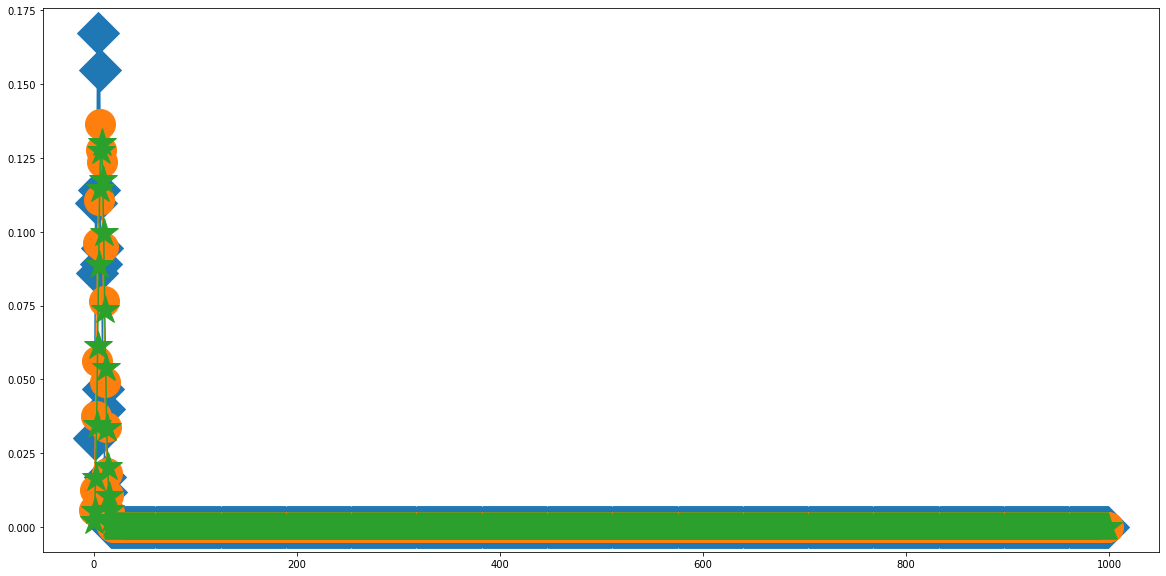

In [4]:
markers = ['D','o','*','v','X','s','H']
PN = ['0.40','0.20','0.10']
hsim = None

for i in range(1,8):
    
    f1 = open("r%d-d0-result.txt"%i)
    raw1 = f1.read()
    f1.close()

    f2 = open("r%d-d1-result.txt"%i)
    raw2 = f2.read()
    f2.close()

    hist,Eb,Es,En,Ps = compute_histogram(raw1,raw2,Tn=100)
    l = "$P_{N}=%s$"%(PN[i-1])
    
    pt.plot(range(len(hist)),hist,'-'+markers[i-1],markersize=30,label=l)
    with open('test-%d.txt'%i,'w') as f:
        for l,k in zip(range(len(hist)),hist):
            print('%.6f\t%.6f',file=f)
    
def pois(l,k):
    v = []
    for x in range(k):
        p = (l**x)*exp(-l)/factorial(x)
        v.append(p)
    return v

#h,b,p = pt.hist(h2,bins=20,density=True,histtype='step',label="Experimental results",align="left",linewidth=5)
#pt.show()

#p = pois(8.339678,20)
#pt.plot(range(20),p,'-g',markersize=25,label='Poisson distribution ($\lambda = 8$)')
#pt.plot(range(len(h)),h,'ob',label="Experimental results ($P_B =50\%$,Ttx=30ms,Trx=60ms)",markersize=20)


pt.axis([0,20,0,0.22])
pt.xticks(range(20), [str(n) for n in range(20)],fontsize=30)
pt.yticks(fontsize=30)
pt.xlabel(r'Throughput [msg/s]', fontsize = 30)
pt.ylabel(r'PDF', fontsize = 30)
pt.legend(fontsize=30)
pt.grid(True)
pt.savefig('change_PN.pdf',format='pdf',dpi=300, bbox_inches='tight')

pt.show()


In [5]:
f1 = open("r4-d0-result.txt")
raw1 = f1.read()
f1.close()

f2 = open("r4-d1-result.txt")
raw2 = f2.read()
f2.close()

hsim,Eb,Es,En,Ps = compute_histogram(raw1,raw2,Tn=100)

<span style="color: #af0000">P(S) = 0.499969</span>

<span style="color: #00af00">P(N) = 0.000000</span>

<span style="color: #0000af">P(B) = 0.500031</span>

r(B)(Events/s) = 16.666994
1.0
r(Suuccess)(Events/s) = 8.333080
r(S)(Events/s) = 8.332825
Success probability evts: 0.499968


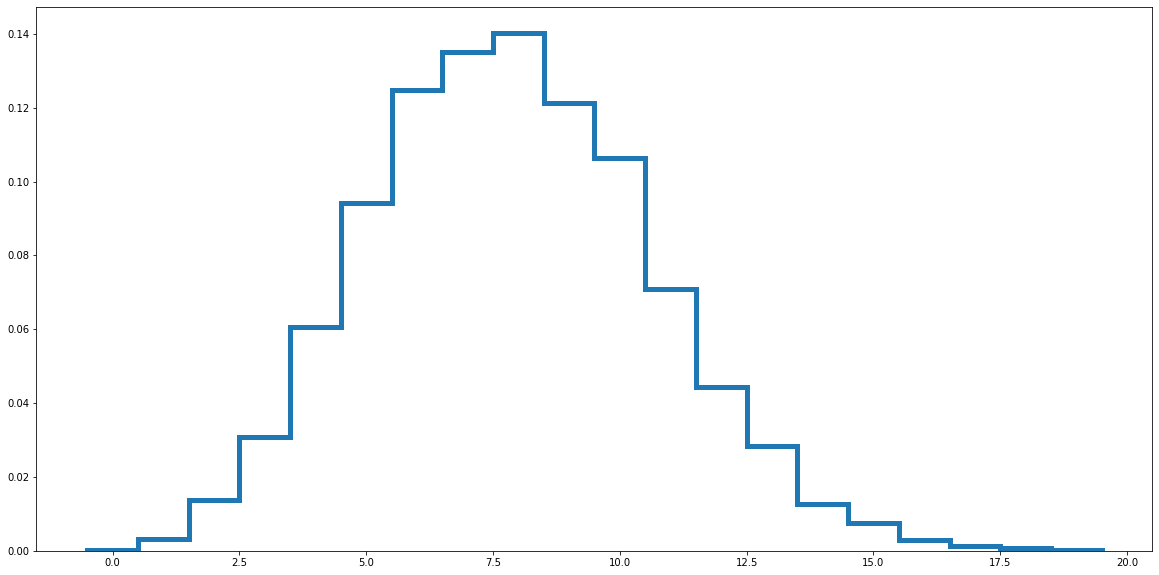

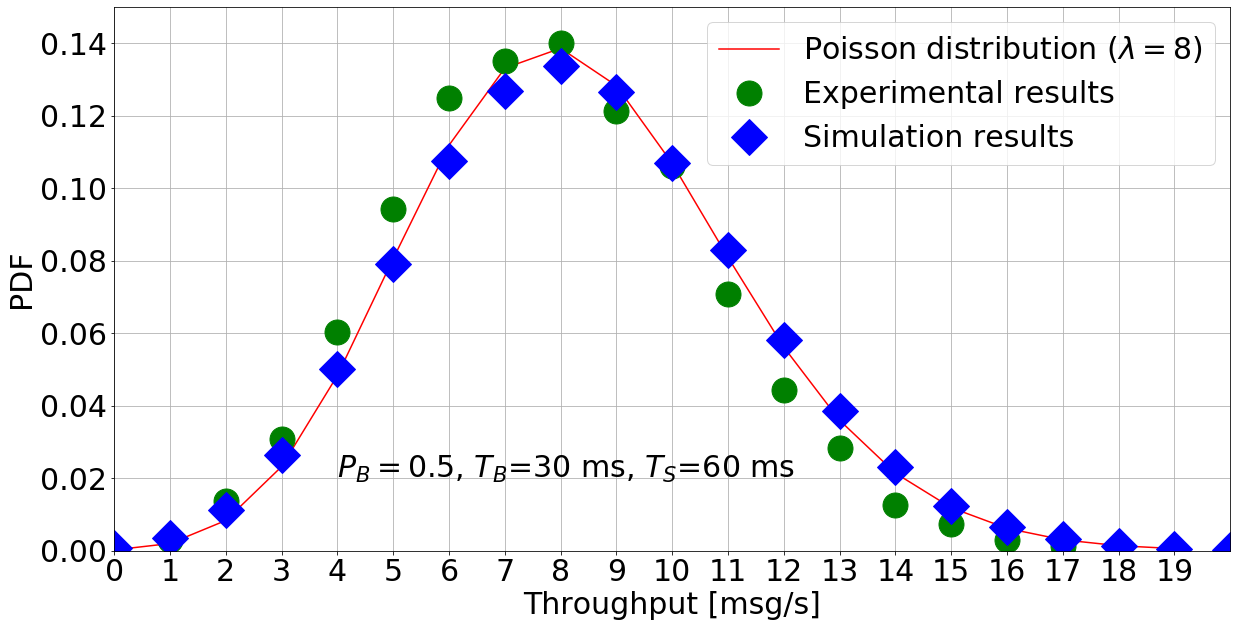

In [9]:
def pois(l,k):
    v = []
    for x in range(k):
        p = (l**x)*exp(-l)/factorial(x)
        v.append(p)
    return v

h,b,p = pt.hist(h2,bins=20,density=True,histtype='step',label="Experimental results",align="left",linewidth=5)
pt.show()

p = pois(8.33,20)
pt.plot(range(20),p,'-r',markersize=25,label='Poisson distribution ($\lambda = 8$)')
pt.plot(range(len(h)),h,'og',label="Experimental results",markersize=25)
pt.plot(range(len(hsim)),hsim,'Db',label="Simulation results",markersize=25)

pt.axis([0,20,0,0.15])
pt.xticks(range(20), [str(n) for n in range(20)],fontsize=30)
pt.yticks(fontsize=30)
pt.xlabel(r'Throughput [msg/s]', fontsize = 30)
pt.ylabel(r'PDF', fontsize = 30)
pt.legend(fontsize=30)
pt.text(4,0.02,"$P_B =0.5$, $T_B$=30 ms, $T_S$=60 ms",fontsize=30)
pt.grid(True)
pt.savefig('sim_vs_experiment.pdf',format='pdf',dpi=300, bbox_inches='tight')
pt.show()

[0.00033546262790251185, 0.002683701023220095, 0.01073480409288038, 0.02862614424768101, 0.05725228849536202, 0.09160366159257924, 0.12213821545677231, 0.13958653195059692, 0.13958653195059692, 0.1240769172894195, 0.09926153383153559, 0.07219020642293499, 0.048126804281956655, 0.029616494942742554, 0.01692371139585289, 0.009025979411121541, 0.004512989705560771, 0.0021237598614403624, 0.0009438932717512722, 0.00039742874600053567]


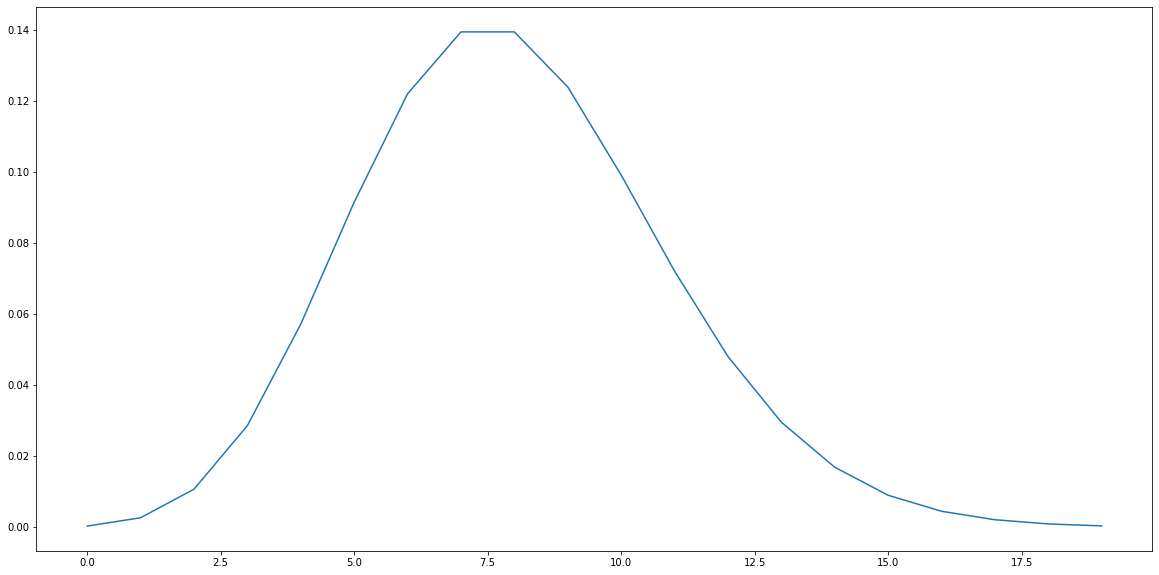

In [7]:
def pois(l,k):
    v = []
    for x in range(k):
        p = (l**x)*exp(-l)/factorial(x)
        v.append(p)
    return v


p = pois(8,20)
print(p)
pt.plot(p)
pt.show()